# TME 7 : Color quantification and search by content


In this practical work session, we will:

- Develop a color based descriptor that can be applied to every image in a database
- Use this color descriptor to create a method that searches images by content: the goal is to find the images that are the most similar to a query.

In [2]:
# Loading useful libraries

import warnings
warnings.filterwarnings('ignore')

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import scipy.ndimage
from skimage.color import rgb2hsv, hsv2rgb

# and useful functions
def setColors(nH, nS, nV):
    """ int**3 -> Array[nH*nS*nV,3]*Array[nH,nS,nV,3]
        computes an RGB palette from a sampling of HSV values
    """
    pal1 = np.zeros((nH*nS*nV, 3))
    pal2 = np.zeros((nH, nS, nV, 3))
    tH, tS, tV = 1/(2*nH), 1/(2*nS), 1/(2*nV)

    idx = 0
    for i in range(nH):
        for j in range(nS):
            for k in range(nV):
                HSVval = np.array([[[i/nH + tH, j/nS + tS, k/nV + tV]]])
                pal1[idx, :] = hsv2rgb(HSVval)*255  
                pal2[i, j, k, :] = hsv2rgb(HSVval)*255
                idx += 1
    return pal1, pal2

def viewQuantizedImage(I,pal):
    """ Array*Array -> Array
        Display an indexed image with colors according to pal 
    """
    Iview = np.empty(I.shape)
    n, m, c = I.shape
    for i in range(n):
        for j in range(m):
            h, s, v = I[i, j, :]
            Iview[i, j, :] = pal[ np.int(h), np.int(s), np.int(v), :]
    #print( Iview.max())
    plt.imshow(Iview/255)
    plt.show()

def display5mainColors(histo, pal):
    """ Array*Array -> NoneType
        Display the 5 main colors in histo 
    """
    idx = np.argsort(histo)
    idx = idx[::-1]
    K = 5
    for i in range (K):
        Ia = np.zeros((1, 1, 3), dtype=np.uint8)
        Ia[0,0,0] = pal[idx[i], 0]
        Ia[0,0,1] = pal[idx[i], 1]
        Ia[0,0,2] = pal[idx[i], 2]
        plt.subplot(1, K, i+1)
        plt.imshow(Ia)
        plt.axis('off')
    plt.show()

def display20bestMatches(S, indexQuery):
    """ Array*int -> NoneType 
    """
    L = S[indexQuery, :]
    Idx = np.argsort(L)[::-1]
    cpt = 1
    plt.figure(figsize=(15, 10))
    for idx in Idx[:20]:
        plt.subplot(5, 4, cpt)
        indexQuery = idx
        imageName = (pathImage+listImage[indexQuery]).strip()
        plt.imshow(np.array(Image.open(imageName))/255.)
        plt.title(listImage[indexQuery])
        plt.axis('off')
        cpt += 1
    plt.show()

## Exercise 1: HSV histogram computation

Each image of the base will be represented by its color histogram in the HSV representation. We use the HSV representation rather that the RGB representation because it is a perceptual color space: two colors that look similar will have close HSV vectors.

1) Write a function ```iv = quantize(v,K)``` that returns the quantize interval of `v` considering a uniform quantization of values over the range $[0,1]$ with `K` evenly spaced intervals. For a image value v=1, the function will return K-1.

In [3]:
def quantize(I, k):
    if I == 1:
        return k-1
    # compute quantisation bounds
    bounds = np.linspace(0, 1, k+1)
    return np.argmax(bounds > I) - 1

# You can test your function with the following lines:
h = np.zeros((8))
for i in range(256):
    h[quantize(i/255.,8)] += 1
    
# assert (h == 31*np.ones((8))).all() # 256/8 = 32
assert (h == 32*np.ones((8))).all()

#### 2) Write a function ```[Iq, histo] = quantificationImage(I,Nh,Ns,Nv)``` that takes as input one image I of size N x M x 3 in the HSV representation and the number of quantification interval needed for H, S and V. 
    Your function will return: 
 *    ```Iq```: the quantified image for each channel, of size N x M x 3
 *   ```hist```: a 3D histogram of size Nh x Ns x Nv that counts the number of pixel for each quantification bin (iH, iS, iV)

In [4]:
def quantizeImage(I, nH, nS, nV):
    Iq = np.zeros(I.shape)
    histo = np.zeros((nH,nS,nV)) # data are distributed according to their hues, saturations, intensities
    for x in range(I.shape[0]):
        for y in range(I.shape[1]):
            # perform the quantisation
            iH = quantize(I[x][y][0], nH)
            iS = quantize(I[x][y][1], nS)
            iV = quantize(I[x][y][2], nV)
            # build the quantised image
            Iq[x][y][0] = iH
            Iq[x][y][1] = iS
            Iq[x][y][2] = iV
            # we then need to count the pixel occurrences for each specific tuple of H, S and V
            histo[iH][iS][iV] += 1 
    # return the quantised image and the histogram that fits it
    return Iq, histo 

3) Write a function ```normalized_histo = NormalizeHistL2(histo)``` that applies a normalization on the histogram ```histo``` according to the L2 norm.
The L2 norm of x can be computed using the function ```numpy.linalg.norm(x,2)```



In [5]:
def normalize(H):
    return H/np.linalg.norm(H,2)

5) Test of the HSV histogram on an image: Complete the following code with your functions in order to apply it on one of the images of the base. The code will follow the following steps:
   1. Open the image and convert it into HSV representation.
   2. Compute the color palette for the display using the given ```setColors(nH, nS, nV)``` function.
   3. Compute the quantization of the image then visualize the quantized image using ```viewQuantizedImage(I,pal) ```.
   4. Transform the 3D histogram into a 1D histogram, normalize it according to L2 norm then visualize it.
   5. Display the 5 most prevalent colors on the image using ```display5mainColors(histo, pal)```.

   You can try this on the image ```Paysages67.png```with ```nH = 12```, ```nS = 3```  and ```nV = 8``` and find a result similar to Figures 1, 2, 3, and 4.

![figure1](./figs/Figure_1.png)
<center>Figure 1: Paysage67.png</center>

![figure2](./figs/Figure_2.png)
<center>Figure 2: Paysage67.png quantized</center>

![figure3](./figs/Figure_3.png)
<center>Figure 3: Histogram of HSV image (288 bins)</center>

![figure4](./figs/Figure_4.png)
<center>Figure 4: 5 main colors</center>


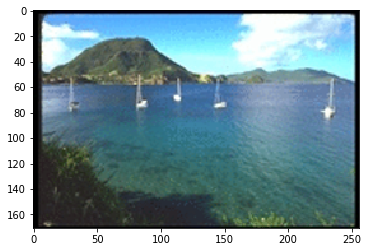

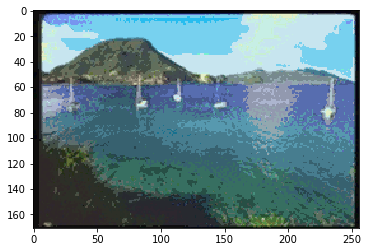

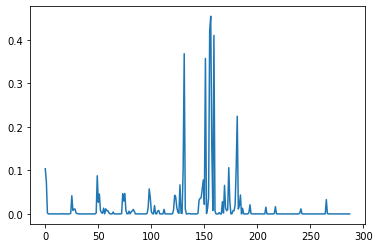

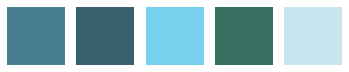

[(6, 1, 4), (6, 1, 3), (6, 1, 7), (5, 1, 3), (6, 0, 7)]


In [6]:
PathImage = './Base/' 
nom = 'Paysages67.png' # a specific example

# preset quantisation parameters
nH = 12
nS = 3
nV = 8

# open and display the specified file
filename = nom
I = np.array(Image.open(PathImage + filename))
I = I / 255.  # I's values range in [0,1]
plt.figure();
plt.imshow(I);
plt.show()

# do :
# HSV conversion
J = rgb2hsv(I)
# full color palette computation
palette, palette2 = setColors(nH, nS, nV);
# image quantisation and visualisation
Iq, histo = quantizeImage(J, nH, nS, nV)
viewQuantizedImage(Iq, palette2)
# histogram flattening
histo = histo.flat
# histogram normalisation
histo = normalize(histo)

# display the changes made
plt.figure()
plt.plot(histo)
plt.show()

# determine the 5 most frequent colors
idx_most_prevalent = (-histo).argsort()[:5]
hsv_most_prevalent = [np.unravel_index(idx,( nH, nS , nV )) for idx in idx_most_prevalent]
display5mainColors(histo, palette)
print(hsv_most_prevalent)

# The output fits the required display.

6) Change the values of ```nH```, ```nS```  and ```nV``` and analyze the results. You can try with other images in the base.

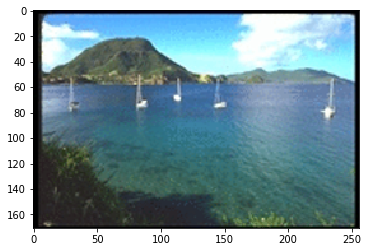

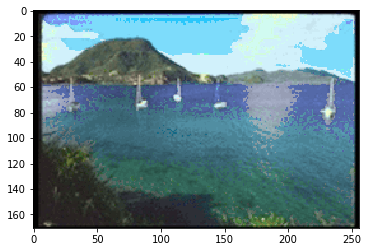

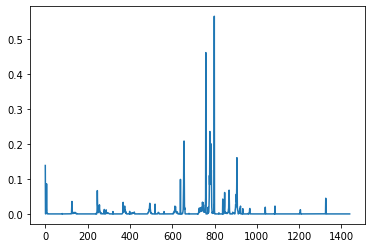

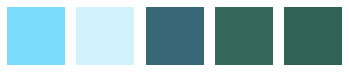

[(6, 1, 39), (6, 0, 39), (6, 1, 18), (5, 1, 16), (5, 1, 15)]


In [63]:
## INCREASING V ##

PathImage = './Base/' 
nom = 'Paysages67.png'

# modified quantisation parameters
nH = 12
nS = 3
nV = 40

# open and display the specified file
filename = nom
I = np.array(Image.open(PathImage + filename))
I = I / 255.  # I's values range in [0,1]
plt.figure();
plt.imshow(I);
plt.show()

# do :
# HSV conversion
J = rgb2hsv(I)
# full color palette computation
palette, palette2 = setColors(nH, nS, nV);
# image quantisation and visualisation
Iq, histo = quantizeImage(J, nH, nS, nV)
viewQuantizedImage(Iq, palette2)
# histogram flattening
histo = histo.flat
# histogram normalisation
histo = normalize(histo)

# display the changes made
plt.figure()
plt.plot(histo)
plt.show()

# determine the 5 most frequent colors
idx_most_prevalent = (-histo).argsort()[:5]
hsv_most_prevalent = [np.unravel_index(idx,( nH, nS , nV )) for idx in idx_most_prevalent]
display5mainColors(histo, palette)
print(hsv_most_prevalent)

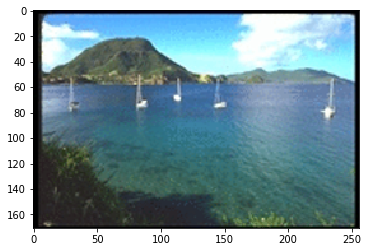

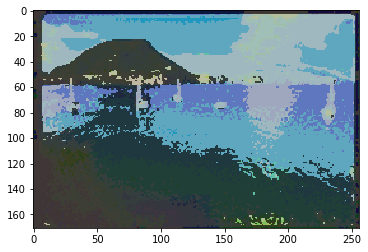

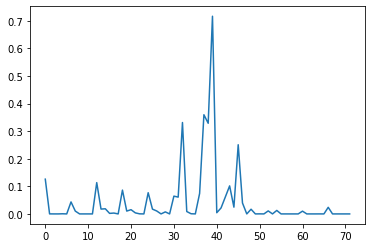

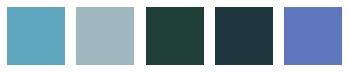

[(6, 1, 1), (6, 0, 1), (5, 1, 0), (6, 1, 0), (7, 1, 1)]


In [64]:
## LOWERING V ##

PathImage = './Base/' 
nom = 'Paysages67.png'

# modified quantisation parameters
nH = 12
nS = 3
nV = 2

# open and display the specified file
filename = nom
I = np.array(Image.open(PathImage + filename))
I = I / 255.  # I's values range in [0,1]
plt.figure();
plt.imshow(I);
plt.show()

# do :
# HSV conversion
J = rgb2hsv(I)
# full color palette computation
palette, palette2 = setColors(nH, nS, nV);
# image quantisation and visualisation
Iq, histo = quantizeImage(J, nH, nS, nV)
viewQuantizedImage(Iq, palette2)
# histogram flattening
histo = histo.flat
# histogram normalisation
histo = normalize(histo)

# display the changes made
plt.figure()
plt.plot(histo)
plt.show()

# determine the 5 most frequent colors
idx_most_prevalent = (-histo).argsort()[:5]
hsv_most_prevalent = [np.unravel_index(idx,( nH, nS , nV )) for idx in idx_most_prevalent]
display5mainColors(histo, palette)
print(hsv_most_prevalent)

In [ ]:
## INITIAL PARAMETERS : ANALYSIS FOR H ##
# We need to change the image to consider something more colourful, since 12 tones can represent all the hues in a landscape,
# but maybe not in a box of candy...

PathImage = './Base/' 
nom = 'Textures69.png'

# modified quantisation parameters
nH = 20
nS = 3
nV = 8

# open and display the specified file
filename = nom
I = np.array(Image.open(PathImage + filename))
I = I / 255.  # I's values range in [0,1]
plt.figure();
plt.imshow(I);
plt.show()

# do :
# HSV conversion
J = rgb2hsv(I)
# full color palette computation
palette, palette2 = setColors(nH, nS, nV);
# image quantisation and visualisation
Iq, histo = quantizeImage(J, nH, nS, nV)
viewQuantizedImage(Iq, palette2)
# histogram flattening
histo = histo.flat
# histogram normalisation
histo = normalize(histo)

# display the changes made
plt.figure()
plt.plot(histo)
plt.show()

# determine the 5 most frequent colors
idx_most_prevalent = (-histo).argsort()[:5]
hsv_most_prevalent = [np.unravel_index(idx,( nH, nS , nV )) for idx in idx_most_prevalent]
display5mainColors(histo, palette)
print(hsv_most_prevalent)

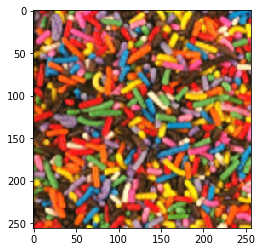

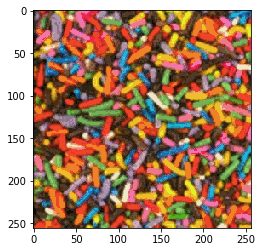

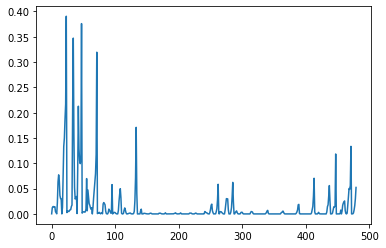

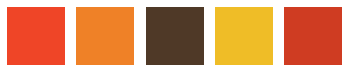

[(0, 2, 7), (1, 2, 7), (1, 1, 2), (2, 2, 7), (0, 2, 6)]


In [66]:
## INCREASING H ##

PathImage = './Base/' 
nom = 'Textures69.png'

# modified quantisation parameters
nH = 20
nS = 3
nV = 8

# open and display the specified file
filename = nom
I = np.array(Image.open(PathImage + filename))
I = I / 255.  # I's values range in [0,1]
plt.figure();
plt.imshow(I);
plt.show()

# do :
# HSV conversion
J = rgb2hsv(I)
# full color palette computation
palette, palette2 = setColors(nH, nS, nV);
# image quantisation and visualisation
Iq, histo = quantizeImage(J, nH, nS, nV)
viewQuantizedImage(Iq, palette2)
# histogram flattening
histo = histo.flat
# histogram normalisation
histo = normalize(histo)

# display the changes made
plt.figure()
plt.plot(histo)
plt.show()

# determine the 5 most frequent colors
idx_most_prevalent = (-histo).argsort()[:5]
hsv_most_prevalent = [np.unravel_index(idx,( nH, nS , nV )) for idx in idx_most_prevalent]
display5mainColors(histo, palette)
print(hsv_most_prevalent)

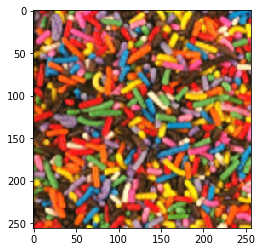

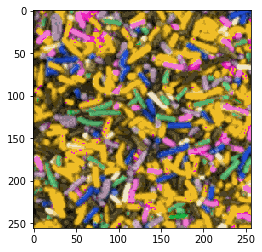

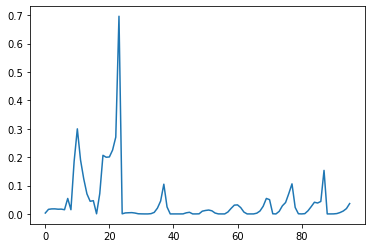

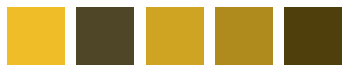

[(0, 2, 7), (0, 1, 2), (0, 2, 6), (0, 2, 5), (0, 2, 2)]


In [67]:
## LOWERING H ##

PathImage = './Base/' 
nom = 'Textures69.png'

# modified quantisation parameters
nH = 4
nS = 3
nV = 8

# open and display the specified file
filename = nom
I = np.array(Image.open(PathImage + filename))
I = I / 255.  # I's values range in [0,1]
plt.figure();
plt.imshow(I);
plt.show()

# do :
# HSV conversion
J = rgb2hsv(I)
# full color palette computation
palette, palette2 = setColors(nH, nS, nV);
# image quantisation and visualisation
Iq, histo = quantizeImage(J, nH, nS, nV)
viewQuantizedImage(Iq, palette2)
# histogram flattening
histo = histo.flat
# histogram normalisation
histo = normalize(histo)

# display the changes made
plt.figure()
plt.plot(histo)
plt.show()

# determine the 5 most frequent colors
idx_most_prevalent = (-histo).argsort()[:5]
hsv_most_prevalent = [np.unravel_index(idx,( nH, nS , nV )) for idx in idx_most_prevalent]
display5mainColors(histo, palette)
print(hsv_most_prevalent)

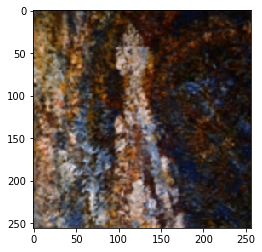

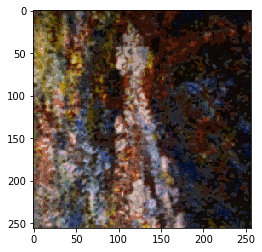

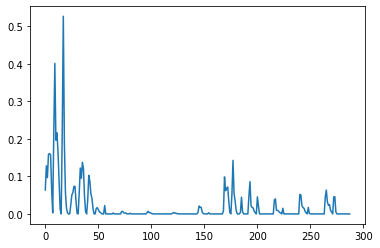

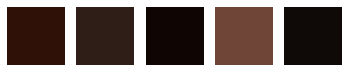

[(0, 2, 1), (0, 1, 1), (0, 2, 0), (0, 1, 3), (0, 1, 0)]


In [71]:
## INITIAL PARAMETERS : ANALYSIS FOR S ##
# We didn't really find an example of an image that relies on a heavy but single-hued colour gradient.
# We did our best !

PathImage = './Base/' 
nom = 'Textures125.png'

# modified quantisation parameters
nH = 12
nS = 3
nV = 8

# open and display the specified file
filename = nom
I = np.array(Image.open(PathImage + filename))
I = I / 255.  # I's values range in [0,1]
plt.figure();
plt.imshow(I);
plt.show()

# do :
# HSV conversion
J = rgb2hsv(I)
# full color palette computation
palette, palette2 = setColors(nH, nS, nV);
# image quantisation and visualisation
Iq, histo = quantizeImage(J, nH, nS, nV)
viewQuantizedImage(Iq, palette2)
# histogram flattening
histo = histo.flat
# histogram normalisation
histo = normalize(histo)

# display the changes made
plt.figure()
plt.plot(histo)
plt.show()

# determine the 5 most frequent colors
idx_most_prevalent = (-histo).argsort()[:5]
hsv_most_prevalent = [np.unravel_index(idx,(nH, nS, nV)) for idx in idx_most_prevalent]
display5mainColors(histo, palette)
print(hsv_most_prevalent)

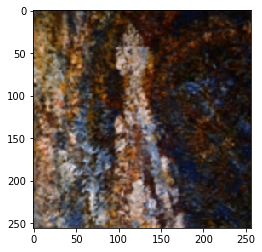

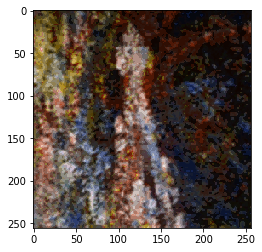

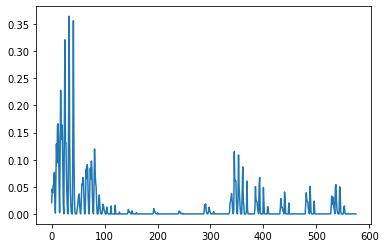

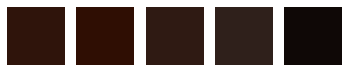

[(0, 4, 1), (0, 5, 1), (0, 3, 1), (0, 2, 1), (0, 3, 0)]


In [69]:
## INCREASING S ##

PathImage = './Base/' 
nom = 'Textures125.png'

# modified quantisation parameters
nH = 12
nS = 6
nV = 8

# open and display the specified file
filename = nom
I = np.array(Image.open(PathImage + filename))
I = I / 255.  # I's values range in [0,1]
plt.figure();
plt.imshow(I);
plt.show()

# do :
# HSV conversion
J = rgb2hsv(I)
# full color palette computation
palette, palette2 = setColors(nH, nS, nV);
# image quantisation and visualisation
Iq, histo = quantizeImage(J, nH, nS, nV)
viewQuantizedImage(Iq, palette2)
# histogram flattening
histo = histo.flat
# histogram normalisation
histo = normalize(histo)

# display the changes made
plt.figure()
plt.plot(histo)
plt.show()

# determine the 5 most frequent colors
idx_most_prevalent = (-histo).argsort()[:5]
hsv_most_prevalent = [np.unravel_index(idx,(nH, nS, nV)) for idx in idx_most_prevalent]
display5mainColors(histo, palette)
print(hsv_most_prevalent)

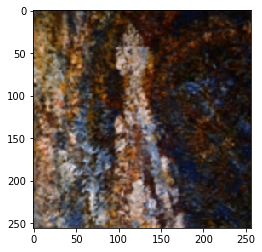

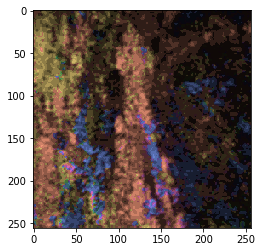

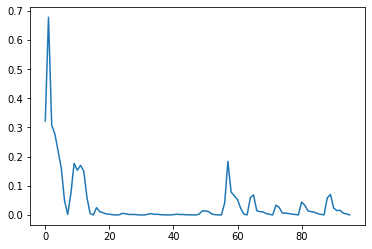

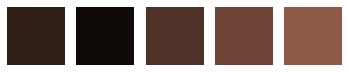

[(0, 0, 1), (0, 0, 0), (0, 0, 2), (0, 0, 3), (0, 0, 4)]


In [70]:
## LOWERING S ##

PathImage = './Base/' 
nom = 'Textures125.png'

# modified quantisation parameters
nH = 12
nS = 1
nV = 8

# open and display the specified file
filename = nom
I = np.array(Image.open(PathImage + filename))
I = I / 255.  # I's values range in [0,1]
plt.figure();
plt.imshow(I);
plt.show()

# do :
# HSV conversion
J = rgb2hsv(I)
# full color palette computation
palette, palette2 = setColors(nH, nS, nV);
# image quantisation and visualisation
Iq, histo = quantizeImage(J, nH, nS, nV)
viewQuantizedImage(Iq, palette2)
# histogram flattening
histo = histo.flat
# histogram normalisation
histo = normalize(histo)

# display the changes made
plt.figure()
plt.plot(histo)
plt.show()

# determine the 5 most frequent colors
idx_most_prevalent = (-histo).argsort()[:5]
hsv_most_prevalent = [np.unravel_index(idx,(nH, nS, nV)) for idx in idx_most_prevalent]
display5mainColors(histo, palette)
print(hsv_most_prevalent)

7) What can you say about the results?

Higher Vs don't change a lot to the quantised picture, but the five most frequent colours seem to be more "precise". Although the hue "bins" on the histogram still look the same, we retain that one version of every hue that *does* dominate on the picture. This improvement is quite slow. We had to multiply V by a minimum factor of 3 to notice any relevant change.
Smaller Vs tend to unify the peaks for every hue "bin" on the histogram. We, of course, lose precision. The quantised colours seem off-tone, they all look very dull.

Higher Hs make big changes on the histogram's shape. Many new bins have appeared, so that we can quantify the colours repartition more accurately : instead of having only "blue" and "violet", we will also consider "lavender"... whatever. This is not needed at all on monochrome pictures, but it might be on colourful ones.
Lower Hs also widen the histogram peaks and yield a quantised image that's totally wrong (different pixel values are brought into the same class, where they shouldn't belong together). Many bins disappear, so we lose a lot of data.

Higher Ss help in representing pictures with shades and gradients (many saturation degrees of the same hue). On the histogram, the peaks in each bin get compounded. The issue is that the recognised "dominant" colours will be very similar.
Lower Ss force all the hues to be "seen" as only one average value in the computation. Each histogram bin is reduced to only one peak. The good thing is that the recognised dominant colours cover a wider range. 

We used very specific cases for this question, to show the limitations of the preset values (if there were any).
However, what we want in general is to get a vague idea of what an image is like,  
so on the average, the H=12, S=3, V=8 values yield very acceptable (optimal ?) results,  
with a tradeoff between the computation time and the amount of relevant information gathered.

## Exercise 2: Similarity between images: 

In this exercice, we will compute a measure of similarity between two images from the normalized histogram. This measure of similarity will be used in order to find images that are the more similar to a given image.

### 2.1 : Computation of the histograms for the whole base

Complete the following script to compute the histograms for every image in the base. As the computation can take a lot of time, we will do it only one time and store the result in ```ListHisto.mat```. The results will be stored as a ```N x M``` array ```listHisto``` with ```N = 1040``` and ```M = nH x nS x nV ```. We will also save the names of the images as ```listImage```

Set ```bcomputed = False``` for the first run to compute the database histograms and then set it to 1.


In [6]:
import os
from scipy.io.matlab.mio import loadmat, savemat

pathImage = './Base/'
listImage = os.listdir(pathImage)
pathDescriptors = './'

# back to preset parameters
nH = 12
nS = 3
nV = 8
bcomputed = False # CAREFUL, do not try this again
if not bcomputed:
    listHisto = []
    print('Histogram database computation ... it may take a while ...')
    for imageName in listImage:
        if os.path.isfile(pathImage+imageName) and imageName[-4:] == '.png':
            print(imageName)
            # read image
            I = np.array(Image.open(pathImage+imageName)) / 255.
            # convert it to HSV
            J = rgb2hsv(I);
            # quantise image
            _,histo = quantizeImage(J, nH, nS, nV)
            # flatten its histogram
            histo = histo.flatten()
            # normalise it
            listHisto.append(normalize(histo))
    print(len(listHisto), "histograms computed")
    nomList = pathDescriptors+'ListHisto.mat'
    savemat(nomList, {'listHisto': np.array(listHisto),
                      'listImage': np.array(listImage)})
    bcomputed = True
else:
    print("Histogram database computation already done.")

Histogram database computation already done.


### 2.2 : Computation of the similarity between every images in the base.

   1. Write a function ```similarityMatrix()``` or a script that performs the similarity computation for every pair of images in the base from the histograms stored in ```listHisto``` and store the result in a ```1024 x 1024``` matrix ```S```. It is possible to make the operation much faster by using only one matrix operation.

In [21]:
mat = loadmat(pathDescriptors+'ListHisto.mat')
listHisto = mat['listHisto']
listImage = mat['listImage']

def similarityMatrix(listHisto):
    S = np.zeros((1040,1040)) # ListHisto.mat contains 1040 histograms
    for h1 in range(len(listHisto)):
        for h2 in range(len(listHisto)):
            # compute the Euclidean distance between any two histograms
            S[h1][h2] = np.linalg.norm(listHisto[h1]-listHisto[h2],2)
    normal = (S-S.min())/(S.max()-S.min())
    return np.abs(1-normal) # return normalised values

2. Display the matrix `S`  as an image. What can we say about it ?

(1040, 1040)


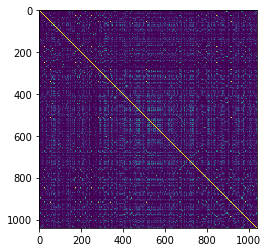

In [22]:
# back to preset parameters
nH = 12
nS = 3
nV = 8
S = similarityMatrix(listHisto)

plt.imshow(S)
print(S.shape)

The similarity matrix is symmetrical (and this seems quite natural as long as we are computing a distance between couples : distances are known to bind objects with a symmetrical relation). Also, the fully highlighted diagonal shows that the similarity peak between each image and the others in the base is always attained for the image itself. This seems natural as well.  

*We know that many other teams noticed small square patches of lighter colours around the diagonal,*  
that may correspond to groups of images that are highly similar, but look really different from all the others (as in some peculiar classes, e.g. the arrows : as we will see it below, there is no way of getting an arrow in a search result if the original image is *not* an arrow).  
We don't have these patches. We believe that our histogram computation was made in some other order, for no apparent reason, and that it dispersed parts of classes that should have stayed together otherwise. A sorting mechanism could have solved the problem, but we have no time left for another 4-hour run of the ListHisto matrix computation. 
The good news is that our algorithms look rather convincing, and that our later results are all perfectly acceptable. The matrix visualisation is the only thing that doesn't look right.

3. Assuming `S` is already computed and using function `display20bestMatches()`, test on the image `Liontigre1.png` (indexQuery = 349). You should obtain something similar to Figure 5.

![figure5.png](./figs/Figure_5.png)
<center>Figure 5: 20 best matches of image 'Liontigre1.png'</center>

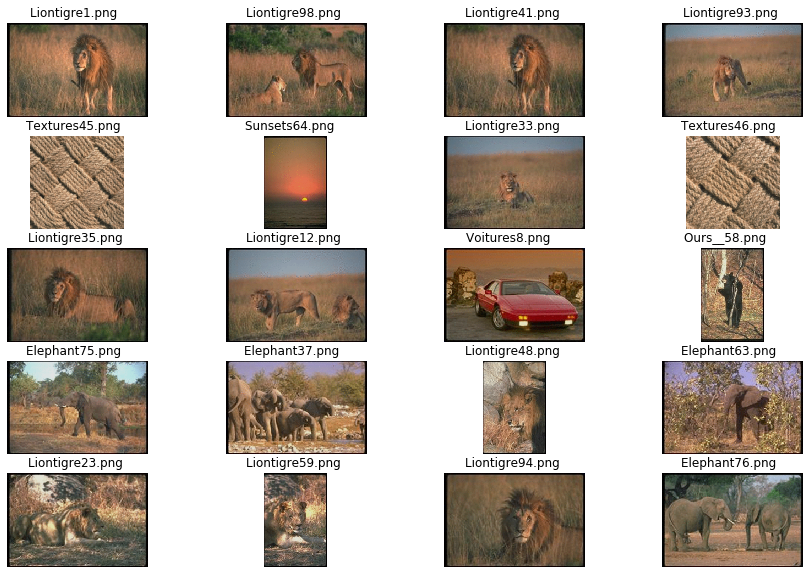

In [18]:
# indexQuery = 349
indexQuery = 537 # The index change might be due to the Mac OS filenames shuffling that was probably done 
                 # while computing ListHisto.mat, followed by computations on other machines with different systems.
display20bestMatches(S, indexQuery)
imageName = (pathImage+listImage[indexQuery]).strip()
# It works as it should anyway.

4. Assuming `S` is already computed, generate a random query (an integer in range $[0, 1030]$), and display the 20 best matches.


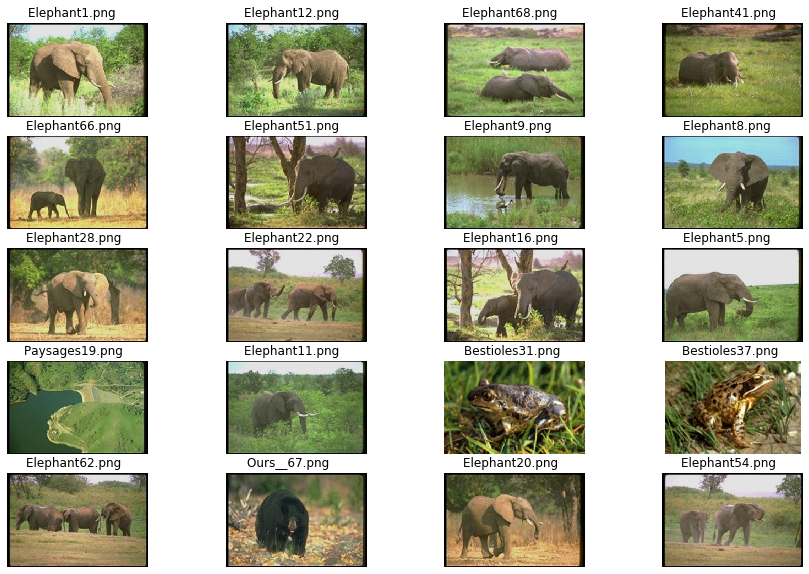

In [33]:
indexQuery = np.random.randint(1030)
display20bestMatches(S, indexQuery)
imageName = (pathImage+listImage[indexQuery]).strip()

# We get elephants mainly, as we are supposed to, 
# but also a few exceptions such as frogs and landscapes,
# for their main colours match the image we seek.

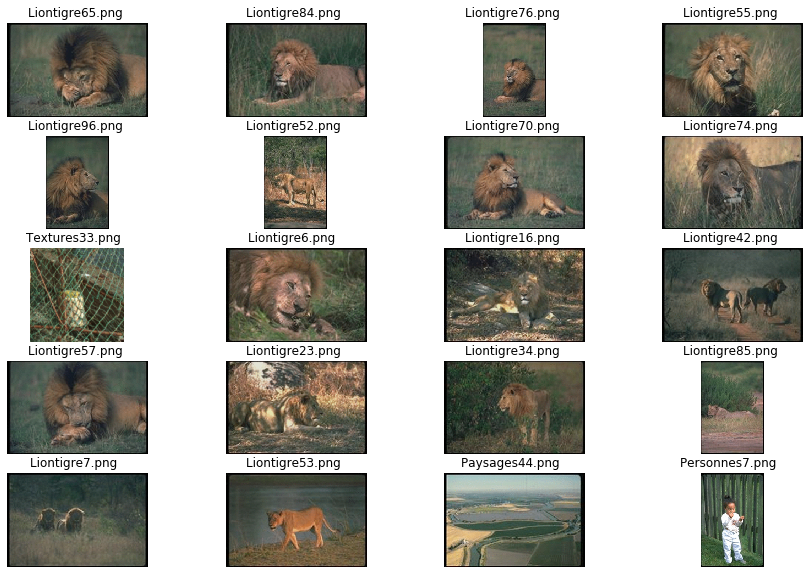

In [24]:
indexQuery = np.random.randint(1030)
display20bestMatches(S, indexQuery)
imageName = (pathImage+listImage[indexQuery]).strip()

# We get lions mainly, 
# a few textures that resemble a lion's fur and the grass around it, 
# and noticably a small lioness at the very end (blame it on her hair colour and on her green environment)

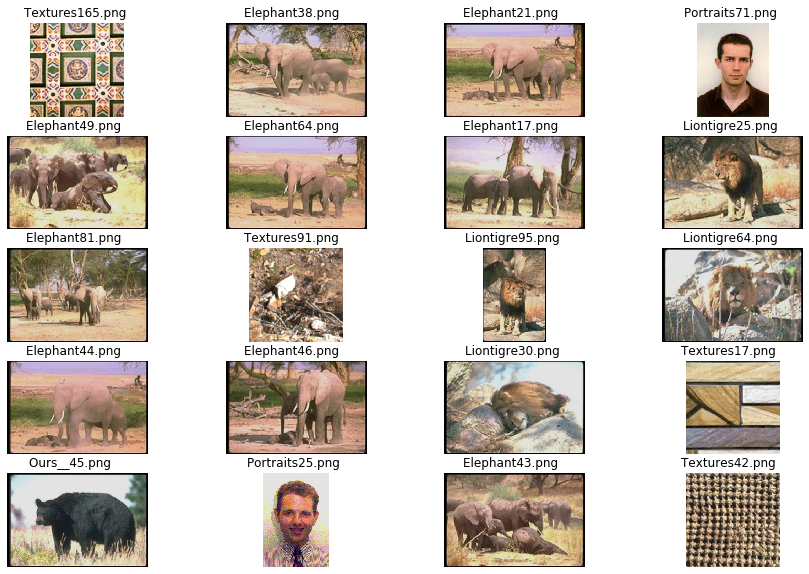

In [61]:
indexQuery = np.random.randint(300)
display20bestMatches(S, indexQuery)
imageName = (pathImage+listImage[indexQuery]).strip()

# Light pictures of all kinds with dominant beige and pink.

5. What can you say about the results ? What are the limitations and the advantages of this method ?

The results always seem to be based on colour atmospheres.

Using histograms as the only tool to compute similarities means that the only image property analysed is colour. We focus on the dominating hues to perform a "classification" (we use this word with caution as no permanent label is ever delivered in the search process). We never consider the semantics of the image : there is not even a shape recognition mechanism.  
We are simply supposing that similar objects always come in the same colours. Since we don't know of any blue lion out there, we deduce that images with a beige mass are rather certainly picturing a lion ; and since the sky and land always tend to be blue and green, we deduce that most landscape images (except for sunsets) will match a picture of a lake.

This is massively imprecise on the semantics side. According to this method, a blue car will never have anything to do with a red car, as long as there is no blue on the background ; not to mention that irrelevant results will appear in the search, e.g. pictures of the sea. That's the main drawback.
On the other hand, this method might be helpful for queries in a database that contains many shots of the same scene. Suppose that we want to gather them. Under the same lighting conditions, and since the objects involved stay the same, the histograms will be very similar (remember that histograms are not sensitive to rotation, translation... etc.). We can guarantee that 19 matching shots will be collected and returned together as they should.

Less importantly, this method could also be highly relevant for an art project. If used on a database of textures, it will help collect samples for any given colour palette. Days of research boiled down to typing only one query : that's coding time well spent.